# Specific Test II. Lens Finding

**Task:** Build a model for classifying the images into lenses using PyTorch or Keras. Pick the most appropriate approach and discuss your strategy.

**Dataset Description:** A data set comprising images with and without strong lenses. 

**Evaluation Metrics:** ROC curve (Receiver Operating Characteristic curve) and AUC score (Area Under the ROC Curve) 

## Strategy

For this test, a slightly modified ResNet101 model was used. After trying out normal feed-formawrd convolutional neural networks and other ResNet models, I decided to use ResNet101 because it has a good balance between accuracy and training time. 

The netowrk is trained for 20 epochs and the criterion used is Binary Cross Entropy Loss. The optimizer used is Adam with a learning rate of 0.001 and StepLR scheduler is used to reduce the learning rate by a factor of 0.1 every 4 epochs.

## Results

**ROC-AUC Score:** 0.9369537481702903

**Training Curve:**

<img src="../results/test-2-training-plot.png" alt="Training plot"/>

**ROC Curve:**

<img src="../results/test-2-roc-plot.png" alt="ROC plot"/>


## Importing Library

In [5]:
import torch
from torch import nn
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from PIL import Image
from tqdm import tqdm
import seaborn as sns
from astropy.io import fits

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Loading Data

In [6]:
base_folder = '../datasets/test2/SpaceBasedTraining/'
df = pd.read_csv(os.path.join(base_folder, 'classifications.csv'))
df["path"] = [os.path.join(base_folder, f"files/imageEUC_VIS-{img_id}.fits") for img_id in df["ID"]]

val_label_map = {0: 'not lensed', 1: 'lensed'}

In [7]:
train_paths, test_paths = train_test_split(df, test_size=0.1, random_state=42)

In [8]:
print(f"Train split:\n{train_paths['is_lens'].value_counts()}")
print(f"\nTest split:\n{test_paths['is_lens'].value_counts()}")

Train split:
1    11315
0     4885
Name: is_lens, dtype: int64

Test split:
1    1259
0     541
Name: is_lens, dtype: int64


In [9]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        path = self.df.iloc[idx].path
        img = fits.getdata(path)
        label = self.df.iloc[idx].is_lens
        targets = torch.zeros(2)
        targets[label] = 1
        img = (img - img.min()) / (img.max() - img.min())
        img = Image.fromarray((img * 255).astype(np.uint8))
        
        if self.transform:
            img = self.transform(img)
        return img, targets

In [10]:
train_transform = transforms.Compose([transforms.RandomVerticalFlip(), transforms.RandomHorizontalFlip(), transforms.Resize(224), transforms.ToTensor()])
test_transform = transforms.Compose([transforms.Resize(224), transforms.ToTensor()])

train_dataset = Dataset(train_paths, transform=train_transform)
test_dataset = Dataset(test_paths, transform=test_transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=2)

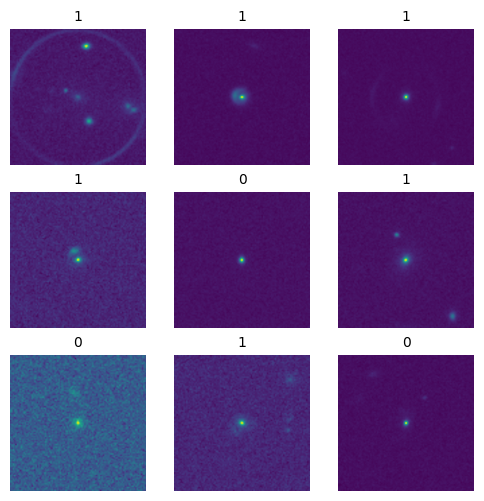

In [11]:
def show_batch(images, targets):
    fig, ax = plt.subplots(3, 3, figsize=(6, 6))
    for i in range(3):
        for j in range(3):
            image = images[i*3 + j]
            target = targets[i*3 + j].numpy()
            target = np.argmax(target)
            ax[i][j].imshow(image.permute(1, 2, 0))
            title = str(target)
            ax[i][j].set_title(title)
            ax[i][j].axis('off')
            ax[i][j].title.set_fontsize(10)
    plt.show()

images, targets = next(iter(train_loader))
show_batch(images, targets)

## Defining Model

In [12]:
from torchvision.models import resnet101, resnet34

class ResNet101(nn.Module):
    def __init__(self, n_classes=2):
        super(ResNet101, self).__init__()
        self.resnet = resnet101()
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.resnet.fc = nn.Sequential(nn.Linear(2048, 512), nn.BatchNorm1d(512), nn.ReLU(), nn.Linear(512, n_classes), nn.Sigmoid())

    def forward(self, x):
        return self.resnet(x)

## Hyperparameters and Training

In [24]:
model = ResNet101(n_classes=2).to(device)

epochs = 20
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

In [25]:
def train(model, epochs, optimizer, criterion, scheduler, device, trainloader, testloader):

    train_losses = []
    train_acc = []
    test_losses = []
    test_acc = []
        
    for i in range(epochs):
        running_loss = 0.0
        running_correct = 0
        total = 0
        best_acc = 0.0
        
        print(f"Epoch: {i + 1}")
        
        for images, targets in tqdm(trainloader, desc= "Train\t"):
            
            images, targets = images.to(device), targets.to(device)
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            pred = torch.argmax(output, dim=1)
            targets = torch.argmax(targets, dim=1)

            running_correct += (pred == targets).sum().item()
            total += targets.size(0)

        scheduler.step()
        
        train_losses.append(running_loss / len(trainloader))
        train_acc.append(running_correct / total)

        running_val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():

            for images, targets in tqdm(testloader, desc= "Test\t"):
                images, targets = images.to(device), targets.to(device)

                output = model(images)
                
                running_val_loss += criterion(output, targets).item()
                preds = torch.argmax(output, dim=1)
                targets = torch.argmax(targets, dim=1)
                correct += (preds == targets).sum().item()
                total += targets.size(0)

            acc = correct / total
            test_acc.append(acc)
            test_losses.append(running_val_loss / len(testloader))

        if test_acc[-1] > best_acc:
            best_acc = test_acc[-1]
            torch.save(model.state_dict(), '../models/test-2-model.pth') 

        print(f"Train Loss: {train_losses[-1]:.3f}, Train Acc: {train_acc[-1]:.3f}, Test Loss: {test_losses[-1]:.3f}, Test Acc: {test_acc[-1]:.3f}\n")

    return train_losses, train_acc, test_losses, test_acc, best_acc

In [26]:
train_losses, train_acc, test_losses, test_acc, best_acc = train(model, epochs, optimizer, criterion, scheduler, device, train_loader, test_loader)

Epoch: 1


Test	: 100%|██████████| 57/57 [00:11<00:00,  5.01it/s]


Train Loss: 0.586, Train Acc: 0.703, Test Loss: 0.538, Test Acc: 0.722

Epoch: 2


Test	: 100%|██████████| 57/57 [00:06<00:00,  8.64it/s]


Train Loss: 0.490, Train Acc: 0.742, Test Loss: 0.416, Test Acc: 0.779

Epoch: 3


Test	: 100%|██████████| 57/57 [00:06<00:00,  8.61it/s]


Train Loss: 0.407, Train Acc: 0.794, Test Loss: 0.393, Test Acc: 0.806

Epoch: 4


Test	: 100%|██████████| 57/57 [00:06<00:00,  8.94it/s]


Train Loss: 0.372, Train Acc: 0.816, Test Loss: 0.360, Test Acc: 0.813

Epoch: 5


Test	: 100%|██████████| 57/57 [00:06<00:00,  8.65it/s]


Train Loss: 0.316, Train Acc: 0.843, Test Loss: 0.318, Test Acc: 0.838

Epoch: 6


Test	: 100%|██████████| 57/57 [00:06<00:00,  8.26it/s]


Train Loss: 0.298, Train Acc: 0.855, Test Loss: 0.324, Test Acc: 0.839

Epoch: 7


Test	: 100%|██████████| 57/57 [00:06<00:00,  8.95it/s]


Train Loss: 0.288, Train Acc: 0.859, Test Loss: 0.300, Test Acc: 0.848

Epoch: 8


Test	: 100%|██████████| 57/57 [00:06<00:00,  8.90it/s]


Train Loss: 0.282, Train Acc: 0.866, Test Loss: 0.296, Test Acc: 0.853

Epoch: 9


Test	: 100%|██████████| 57/57 [00:06<00:00,  8.20it/s]


Train Loss: 0.272, Train Acc: 0.870, Test Loss: 0.308, Test Acc: 0.859

Epoch: 10


Test	: 100%|██████████| 57/57 [00:06<00:00,  8.78it/s]


Train Loss: 0.262, Train Acc: 0.873, Test Loss: 0.301, Test Acc: 0.854

Epoch: 11


Test	: 100%|██████████| 57/57 [00:06<00:00,  8.99it/s]


Train Loss: 0.264, Train Acc: 0.874, Test Loss: 0.288, Test Acc: 0.867

Epoch: 12


Test	: 100%|██████████| 57/57 [00:06<00:00,  8.16it/s]


Train Loss: 0.265, Train Acc: 0.875, Test Loss: 0.282, Test Acc: 0.859

Epoch: 13


Test	: 100%|██████████| 57/57 [00:06<00:00,  8.81it/s]


Train Loss: 0.258, Train Acc: 0.879, Test Loss: 0.286, Test Acc: 0.856

Epoch: 14


Test	: 100%|██████████| 57/57 [00:06<00:00,  8.68it/s]


Train Loss: 0.260, Train Acc: 0.877, Test Loss: 0.288, Test Acc: 0.863

Epoch: 15


Test	: 100%|██████████| 57/57 [00:06<00:00,  8.27it/s]


Train Loss: 0.260, Train Acc: 0.877, Test Loss: 0.290, Test Acc: 0.862

Epoch: 16


Test	: 100%|██████████| 57/57 [00:06<00:00,  8.89it/s]


Train Loss: 0.258, Train Acc: 0.879, Test Loss: 0.300, Test Acc: 0.852

Epoch: 17


Test	: 100%|██████████| 57/57 [00:06<00:00,  8.72it/s]


Train Loss: 0.258, Train Acc: 0.881, Test Loss: 0.298, Test Acc: 0.854

Epoch: 18


Test	: 100%|██████████| 57/57 [00:06<00:00,  8.19it/s]


Train Loss: 0.257, Train Acc: 0.878, Test Loss: 0.293, Test Acc: 0.867

Epoch: 19


Test	: 100%|██████████| 57/57 [00:06<00:00,  9.10it/s]


Train Loss: 0.257, Train Acc: 0.878, Test Loss: 0.291, Test Acc: 0.856

Epoch: 20


Test	: 100%|██████████| 57/57 [00:06<00:00,  8.89it/s]


Train Loss: 0.258, Train Acc: 0.877, Test Loss: 0.288, Test Acc: 0.858



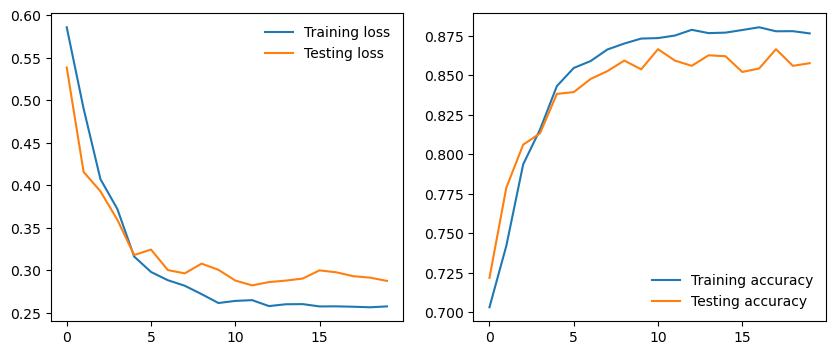

In [27]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Testing loss')
plt.legend(frameon=False)

plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training accuracy')
plt.plot(test_acc, label='Testing accuracy')
plt.legend(frameon=False)

## Testing

In [13]:
model = ResNet101().to(device)
model.load_state_dict(torch.load('../models/test-2-model.pth'))

<All keys matched successfully>

In [15]:
y_true = []
y_pred_class = []
y_pred_prob = []

with torch.no_grad():
    for images, targets in tqdm(test_loader):
        images, targets = images.to(device), targets.to(device)
        output = model(images)
        preds = torch.argmax(output, dim=1)
        targets = torch.argmax(targets, dim=1)
        y_true.extend(targets.cpu().numpy())
        y_pred_class.extend(preds.cpu().numpy())
        y_pred_prob.extend(output.cpu().numpy())

100%|██████████| 57/57 [00:11<00:00,  4.84it/s]


In [16]:
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, classification_report, auc

print(classification_report(y_true, y_pred_class))

              precision    recall  f1-score   support

           0       0.75      0.77      0.76       541
           1       0.90      0.89      0.90      1259

    accuracy                           0.85      1800
   macro avg       0.83      0.83      0.83      1800
weighted avg       0.85      0.85      0.85      1800



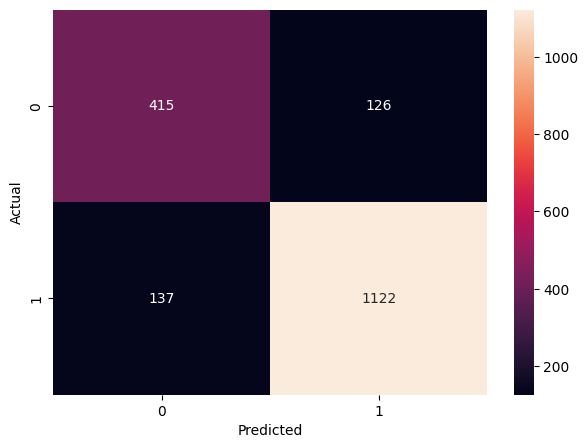

In [17]:
conf_matrix = confusion_matrix(y_true, y_pred_class)
plt.figure(figsize=(7, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [18]:
print(f"ROC-AUC Score: {roc_auc_score(y_true, np.array(y_pred_prob)[:,1], multi_class='ovr')}")

ROC-AUC Score: 0.9369537481702903


not lensed ROC-AUC: 0.9369508118258336
lensed   ROC-AUC: 0.9369537481702903


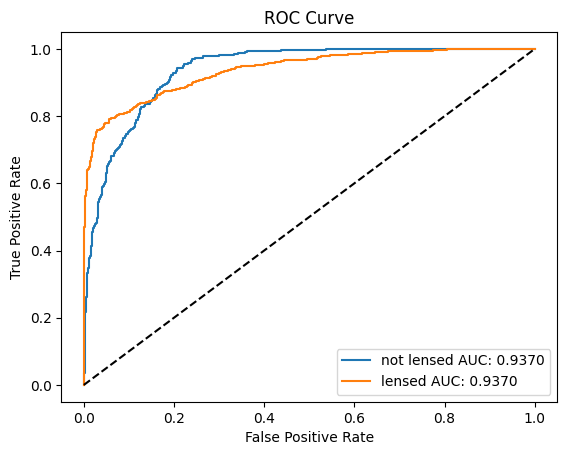

In [19]:
y_true_dummies = pd.get_dummies(y_true).values

auc_scores = {}
for i in range(2):
    fpr_i, tpr_i, thresholds_i = roc_curve(y_true_dummies[:, i], np.array(y_pred_prob)[:, i])
    auc_score = auc(fpr_i, tpr_i)
    print(f"{(val_label_map[i]).ljust(8)} ROC-AUC: {auc_score}")
    auc_scores[val_label_map[i]] = auc_score
    plt.plot(fpr_i, tpr_i, label=f"{(val_label_map[i]).ljust(6)} AUC: {auc_score:.4f}")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()